In [12]:
from QLBM import QLBM
import numpy as np
import matplotlib.pyplot as plt
import qiskit_aer
from qiskit import transpile

In [13]:
N_POINTS_X=64
N_POINTS_Y=64
x_0 = np.arange(N_POINTS_X)
y_0 = np.arange(N_POINTS_Y)
timesteps=10
c_s=1/np.sqrt(3)
NUMBER_DISCRETE_VELOCITIES = 5  #D2Q5

#Gaussian hill variables
Psi=0.3                 #initial concentration of the peak of the hill
Psi_ambient = 0       #ambient scalar field
sigma_0=5               #width of the gaussian hill
u=0.2                   #velocity in x
v=0.2                   #velocity in y
x=[N_POINTS_X/2,N_POINTS_Y/2]                    #initial center of the gaussian hill

Psi_init = np.zeros([N_POINTS_X,N_POINTS_Y])
r = np.zeros(2)
for i in range(N_POINTS_X):
    for j in range(N_POINTS_Y):
        r[0]=x[0]-x_0[i]
        r[1]=x[1]-y_0[j]
        Psi_init[i,j]=Psi*np.exp(-np.dot(r,r)/(2*(sigma_0**2)))+Psi_ambient


D=0.3*c_s**2            #diffusion coefficient

In [14]:
simulator = qiskit_aer.backends.statevector_simulator.StatevectorSimulator()

In [15]:
# Initialize the quantum LBM scalar field
Psi_qlbm = np.zeros((timesteps + 1, N_POINTS_X, N_POINTS_Y))
Psi_qlbm[0, :, :] = Psi_init  # Set initial condition from the Gaussian hill

# Quantum LBM simulation loop
for t in range(timesteps):
    # Initialize velocity field for the current timestep
    u_LBM = np.ones((N_POINTS_X, N_POINTS_Y, 2))
    u_LBM[:, :, 0] *= u  # Set the x-component of the velocity
    u_LBM[:, :, 1] *= v  # Set the y-component of the velocity

    # Create and run the quantum circuit for LBM
    qc = QLBM(density_field=Psi_qlbm[t, :, :], velocity_field=u_LBM, number_velocities=NUMBER_DISCRETE_VELOCITIES)
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()
    
    # Process the quantum statevector to update Psi_qlbm
    statevector = np.array(result.get_statevector())
    real_part_statevector = np.real(statevector[:N_POINTS_X * N_POINTS_Y])
    real_part_statevector_reshaped = np.reshape(real_part_statevector, (N_POINTS_X, N_POINTS_Y))
    
    # Normalize and update the scalar field for the next timestep
    Psi_qlbm[t + 1, :, :] = real_part_statevector_reshaped * np.linalg.norm(Psi_qlbm[t, :, :].flatten()) * (4 / np.sqrt(2))

In [16]:
# Initialize the classical LBM scalar field
Psi_lbm = np.zeros((timesteps + 1, N_POINTS_X, N_POINTS_Y))
Psi_lbm[0, :, :] = Psi_init  # Set initial Gaussian hill as the starting condition

# Lattice parameters for D2Q5
LATTICE_VELOCITIES = np.array([0, 1, -1, 1, -1])  # Corresponding to f0, f1, f2, f3, f4
LATTICE_WEIGHTS = np.array([1/3, 1/6, 1/6, 1/6, 1/6])

# Initialize f to store all distribution functions
f = np.zeros((NUMBER_DISCRETE_VELOCITIES, N_POINTS_X, N_POINTS_Y))

# Classical LBM simulation loop
for t in range(timesteps):
    # Calculate equilibrium distributions for each velocity direction and store in f
    f[0] = LATTICE_WEIGHTS[0] * Psi_lbm[t, :, :]
    f[1] = LATTICE_WEIGHTS[1] * Psi_lbm[t, :, :] * (1 + (LATTICE_VELOCITIES[1] * u / c_s**2))
    f[2] = LATTICE_WEIGHTS[2] * Psi_lbm[t, :, :] * (1 + (LATTICE_VELOCITIES[2] * u / c_s**2))
    f[3] = LATTICE_WEIGHTS[3] * Psi_lbm[t, :, :] * (1 + (LATTICE_VELOCITIES[3] * v / c_s**2))
    f[4] = LATTICE_WEIGHTS[4] * Psi_lbm[t, :, :] * (1 + (LATTICE_VELOCITIES[4] * v / c_s**2))

    # Streaming step: Shift each distribution along its corresponding velocity direction
    f[1] = np.roll(f[1], LATTICE_VELOCITIES[1], axis=1)  # Shift f1 along y-axis (right)
    f[2] = np.roll(f[2], LATTICE_VELOCITIES[2], axis=1)  # Shift f2 along y-axis (left)
    f[3] = np.roll(f[3], LATTICE_VELOCITIES[3], axis=0)  # Shift f3 along x-axis (up)
    f[4] = np.roll(f[4], LATTICE_VELOCITIES[4], axis=0)  # Shift f4 along x-axis (down)

    # Update scalar field by summing over all distribution functions
    Psi_lbm[t + 1, :, :] = np.sum(f, axis=0)

In [17]:
# Initialize variables
r = [0, 0]
Psi_analytical = np.zeros((timesteps, N_POINTS_X, N_POINTS_Y))

# Loop over timesteps to compute the analytical solution
for k in range(timesteps):
    # Calculate sigma for the current timestep
    sigma_D = np.sqrt(2 * D * (k + 1))
    factor = sigma_0**2 / (sigma_0**2 + sigma_D**2)

    for i in range(N_POINTS_X):
        for j in range(N_POINTS_Y):
            # Update position vector r for the current grid point and timestep
            r[0] = x[0] - x_0[i] + (k + 1) * u
            r[1] = x[1] - y_0[j] + (k + 1) * v
            
            # Compute the Gaussian concentration at this point
            distance_squared = r[0]**2 + r[1]**2
            Psi_analytical[k, i, j] = factor * Psi * np.exp(-distance_squared / (2 * (sigma_0**2 + sigma_D**2)))

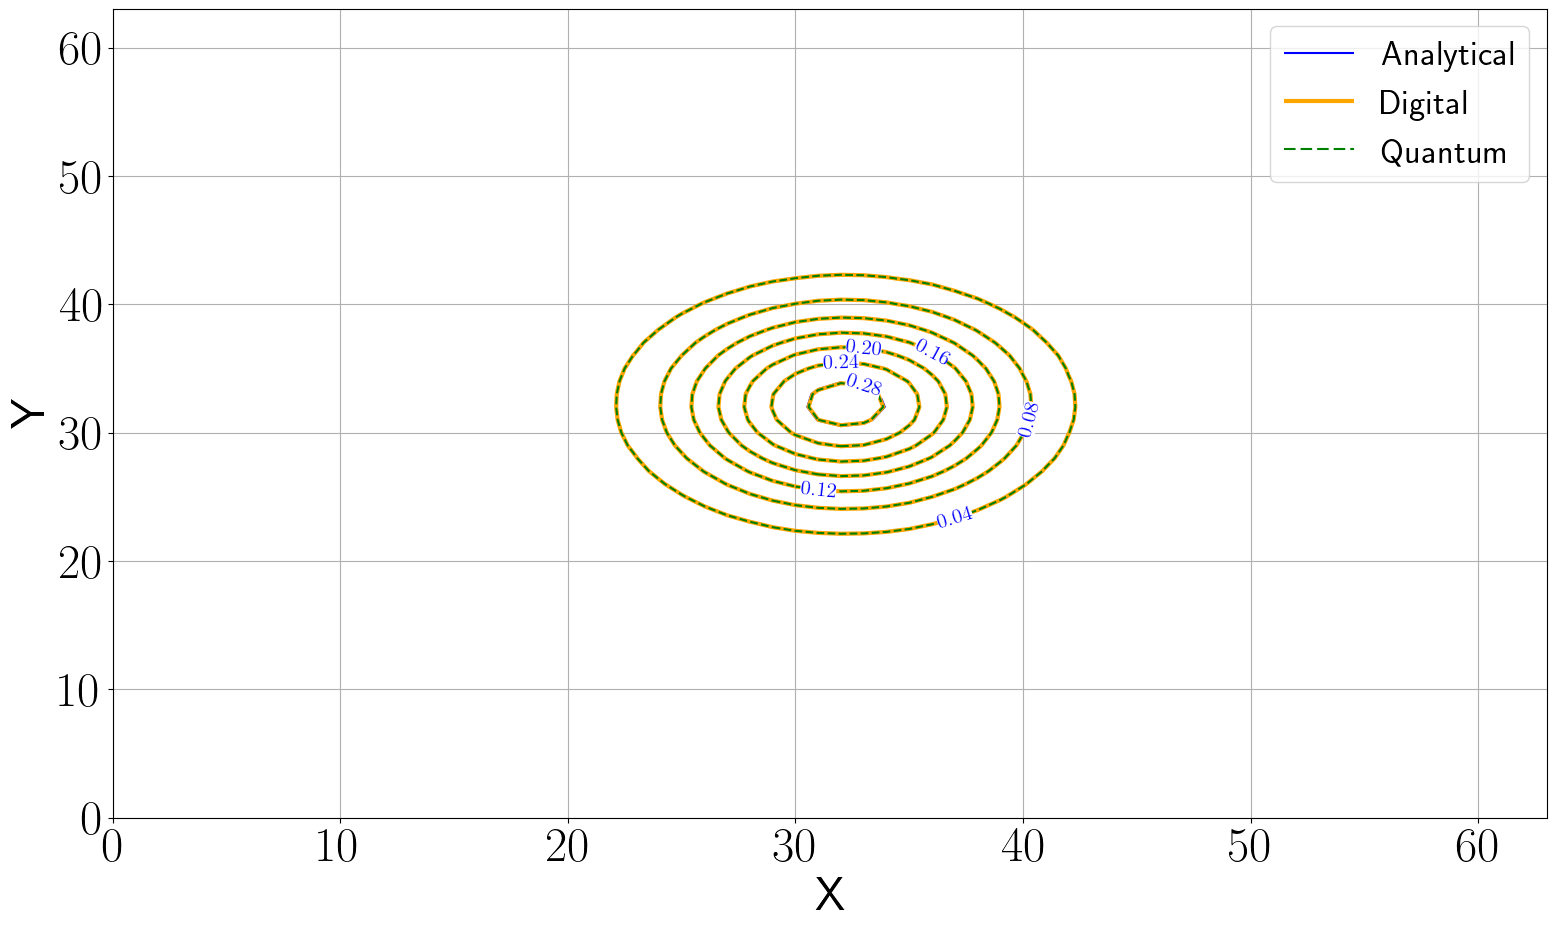

In [18]:
plt.rcParams.update({'font.size': 35})
plt.rcParams['text.usetex'] = True

# Create a meshgrid for plotting
X, Y = np.meshgrid(x_0, y_0)

# Select the timestep to plot
t = 0

# Create the plot figure and axis
fig, ax = plt.subplots(figsize=(18.5, 10.5), dpi=100)

# Plot contours for analytical, digital, and quantum LBM fields
a = ax.contour(X, Y, Psi_analytical[t, :, :], colors='blue')
b = ax.contour(X, Y, Psi_lbm[t + 1, :, :], colors='orange', linewidths=3)
c = ax.contour(X, Y, Psi_qlbm[t + 1, :, :], linestyles='dashed', colors='green')

# Remove the first level from digital and quantum contours for better visualization
if len(b.allsegs[0]) > 0:
    b.allsegs[0] = b.allsegs[0][1:]
if len(c.allsegs[0]) > 0:
    c.allsegs[0] = c.allsegs[0][1:]

# Generate legend handles for each contour plot
h1, _ = a.legend_elements()
h2, _ = b.legend_elements()
h3, _ = c.legend_elements()

# Label contours for the analytical solution
clabels = ax.clabel(a, inline=True, fontsize=15)
# Remove bounding boxes from contour labels
for txt in clabels:
    txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0))

# Customize plot appearance
ax.grid()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'Digital', 'Quantum'], prop={'size': 25})

plt.show()

In [19]:
# Initialize MSE and RMSE arrays
MSE = np.zeros(timesteps)
RMSE = np.zeros(timesteps)

# Remove the initial condition from the classical and quantum fields
Psi_classical_no_init = Psi_lbm[1:, :, :]
Psi_quantum_no_init = Psi_qlbm[1:, :, :]

# Calculate MSE and RMSE for each timestep
for t in range(timesteps):
    difference = Psi_quantum_no_init[t, :, :] - Psi_classical_no_init[t, :, :]
    MSE[t] = np.mean(np.square(difference))
    RMSE[t] = np.sqrt(MSE[t])

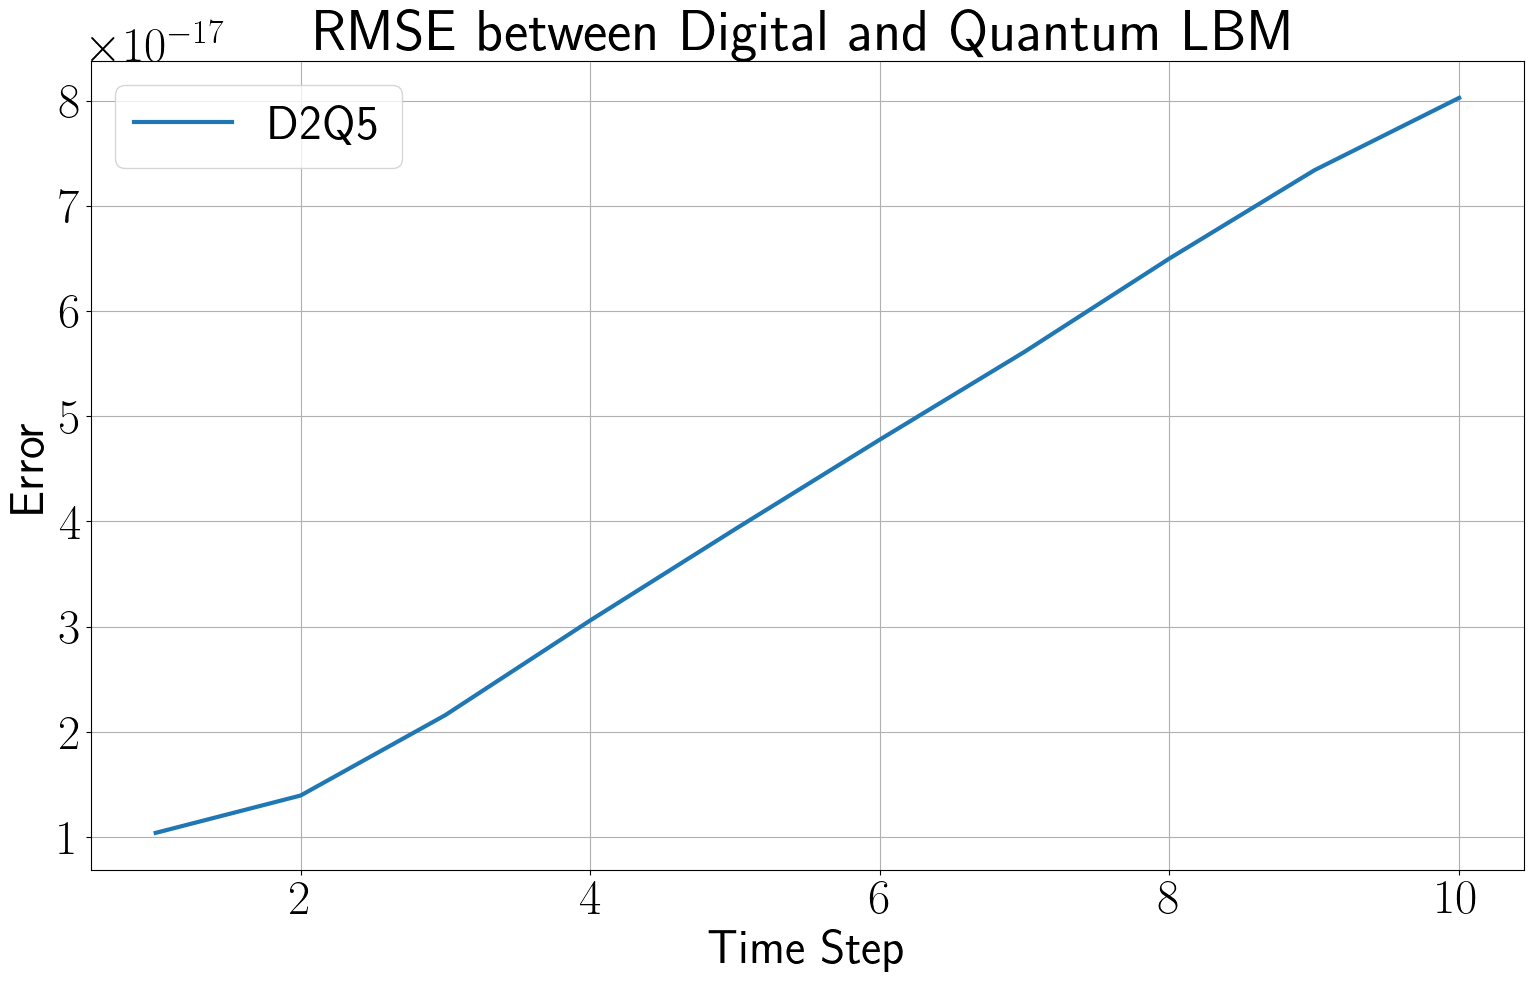

In [20]:
# Update plot settings
plt.rcParams.update({'font.size': 35})
plt.rcParams['text.usetex'] = True

# Plot RMSE over time
plt.figure(figsize=(18.5, 10.5), dpi=100)
plt.plot(range(1, timesteps + 1), RMSE, linewidth=3, label='D2Q5')
plt.grid()

# Add legend, title, and axis labels
plt.legend(loc='best')
plt.title('RMSE between Digital and Quantum LBM')
plt.ylabel('Error')
plt.xlabel('Time Step')

plt.show()